# FULL Student Dropout Prediction Notebook - Cleaned with All Visualizations

## %% [markdown]
# # Student Dropout Prediction - Complete ML Pipeline
# 
# **Objective:** Identify at-risk students early using socioeconomic and academic features
# 
# **Integration:** Model will be exported for use in Big Data Pipeline & Ministry Decision-Making
# 
# **Timeline:** 15 days | **Team Size:** 5 people
# 
# ---

## %% [markdown]
# ## 1. Setup Dependencies


In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, recall_score, 
    accuracy_score, roc_auc_score, precision_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import geometric_mean_score
import warnings
warnings.filterwarnings('ignore')
import joblib
import json
from datetime import datetime
import os
# Create figures directory
os.makedirs('figures', exist_ok=True)
print("✓ Created 'figures/' directory for saving plots")

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✓ All dependencies loaded successfully!")

✓ Created 'figures/' directory for saving plots
✓ All dependencies loaded successfully!



# ## 2. Load and Explore Data



In [2]:
df = pd.read_csv("./data/dataset.csv")


# Convert to binary target for Ministry use case
print("\nConverting to binary target (Dropout vs Not Dropout)...")
target_mapping = {'Dropout': 1, 'Graduate': 0, 'Enrolled': 0}
df['Dropout'] = df['Target'].map(target_mapping)

print("Dataset shape:", df.shape)
print("Binary target distribution:")
print(df['Dropout'].value_counts())



print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nDataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nFirst 5 rows:")
display(df.head())

print("\nData Types and Missing Values:")
print(df.info())

print("\nBasic Statistics:")
display(df.describe())

# Handle missing values
print(f"\nMissing values:\n{df.isnull().sum().sum()} total missing")
df = df.dropna()

print(f"After cleaning: {df.shape}")


# Create binary target for Ministry focus (Dropout vs Not Dropout)
print("\n" + "="*60)
print("CONVERTING TO BINARY TARGET: Dropout vs Not Dropout")
print("="*60)

# Create binary target column
df['Dropout'] = df['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

# Display distribution
print("\nBinary Target Distribution:")
print(f"Dropout students: {df['Dropout'].sum()} ({df['Dropout'].mean()*100:.2f}%)")
print(f"Not Dropout students: {len(df) - df['Dropout'].sum()} ({(1-df['Dropout'].mean())*100:.2f}%)")

# Update target_col variable to use binary target
target_col = 'Dropout'  # This will be used throughout the rest of the notebook
print("\n✓ Using binary target for all subsequent analysis")


Converting to binary target (Dropout vs Not Dropout)...
Dataset shape: (4424, 36)
Binary target distribution:
Dropout
0    3003
1    1421
Name: count, dtype: int64
DATASET OVERVIEW

Dataset shape: 4424 rows × 36 columns

First 5 rows:


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Dropout
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate,0
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout,1
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate,0
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate,0



Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's 

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Dropout
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,6.886980,1.727848,9.899186,0.890823,2.531420,1.254521,12.322107,16.455244,7.317812,7.819168,0.548373,0.011528,0.113698,0.880651,0.351718,0.248418,23.265145,0.024864,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969,0.321203
std,0.605747,5.298964,1.313793,4.331792,0.311897,3.963707,1.748447,9.026251,11.044800,3.997828,4.856692,0.497711,0.106760,0.317480,0.324235,0.477560,0.432144,7.587816,0.155729,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935,0.466991
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,2.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,1.000000,8.000000,1.000000,10.000000,1.000000,1.000000,1.000000,13.000000,14.000000,6.000000,8.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,0.000000
75%,1.000000,12.000000,2.000000,13.000000,1.000000,1.000000,1.000000,22.000000,27.000000,10.000000,10.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,0.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,1.000000
max,6.000000,18.000000,9.000000,17.000000,1.000000,17.000000,21.000000,29.000000,34.000000,32.000000,46.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,1.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000,1.000000



Missing values:
0 total missing
After cleaning: (4424, 36)

CONVERTING TO BINARY TARGET: Dropout vs Not Dropout

Binary Target Distribution:
Dropout students: 1421 (32.12%)
Not Dropout students: 3003 (67.88%)

✓ Using binary target for all subsequent analysis


In [3]:
# Convert Target to numeric classes
target_mapping = {'Dropout': 1, 'Graduate': 0, 'Enrolled': 0}
df['Target_Numeric'] = df['Target'].map(target_mapping)

# Use binary target for Ministry focus
df['Dropout'] = df['Target_Numeric']  # 1 = Dropout, 0 = Not Dropout

# ## 3. Exploratory Data Analysis (EDA)


TARGET DISTRIBUTION

Target Distribution:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


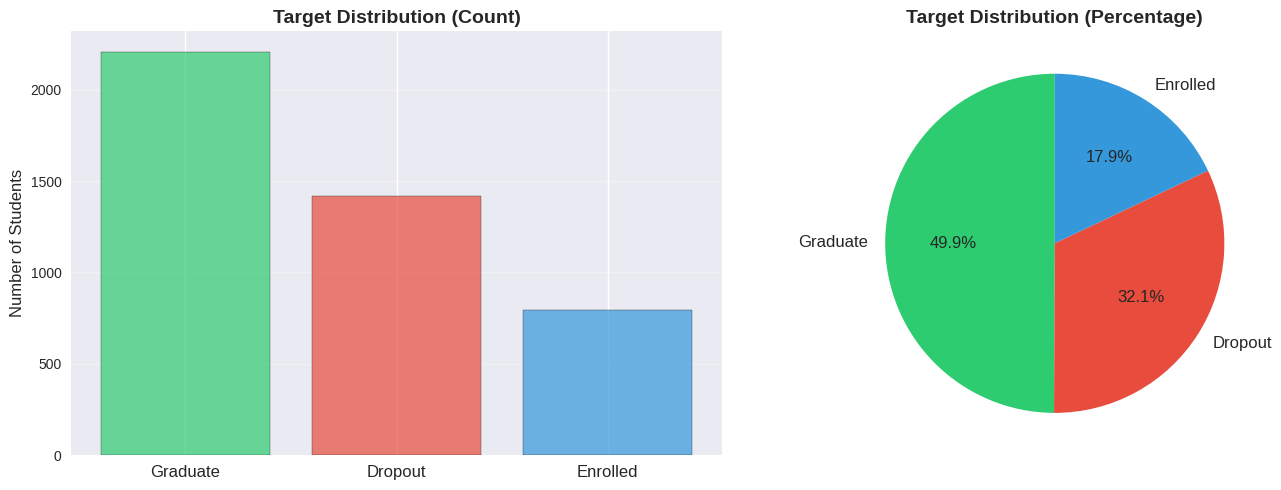


Numerical Features: 36
Categorical Features: 1


In [4]:

# Check target distribution
print("\n" + "="*60)
print("TARGET DISTRIBUTION")
print("="*60)

if 'Target' in df.columns:
    target_col = 'Target'
elif 'Dropout' in df.columns:
    target_col = 'Dropout'
else:
    target_col = df.columns[-1]

print(f"\n{target_col} Distribution:")
print(df[target_col].value_counts())

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
ax1 = axes[0]
value_counts = df[target_col].value_counts()
colors = ['#2ecc71', '#e74c3c', '#3498db'][:len(value_counts)]
ax1.bar(range(len(value_counts)), value_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(value_counts)))
ax1.set_xticklabels(value_counts.index, fontsize=12)
ax1.set_title(f'{target_col} Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Students', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Percentage plot
ax2 = axes[1]
percentages = (value_counts / len(df) * 100).values
ax2.pie(percentages, labels=value_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90, textprops={'fontsize': 12})
ax2.set_title(f'{target_col} Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Numerical features distribution
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if target_col in numerical_cols:
    numerical_cols.remove(target_col)

print(f"\nNumerical Features: {len(numerical_cols)}")
print(f"Categorical Features: {len(df.select_dtypes(include=['object']).columns)}")


# ## 4. Data Preprocessing (Define Once)


In [24]:
# GOOD features (available at enrollment):
enrollment_features = [
    'Marital status', 'Application mode', 'Application order', 'Course',
    'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
    "Mother's qualification", "Father's qualification", "Mother's occupation", 
    "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment',
    'International'
]

# BAD features (leak future performance - REMOVE THESE):
performance_features = [
    'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP'
]

# Ensure BINARY target for ROC curves
if 'Target' in df.columns:
    # Convert to binary: 1 = Dropout, 0 = Not Dropout
    df['Dropout'] = df['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)
    y = df['Dropout'].values
    target_col = 'Dropout'

# Prepare features and target
X = df.drop(['Target', 'Dropout'], axis=1)
y = df['Dropout'].values  # Integer array [0, 1, 0, ...]



# After creating X and y:
print("✓ Removing future-performance features to prevent data leakage")
X = X[enrollment_features]  # Only keep enrollment-time features

print(f"After removing leakage features: {X.shape[1]} features remaining")
print("Available features:", X.columns.tolist())




print(f"Class distribution: {np.bincount(y)}")  # ✅ Works now!
print(f"\n✓ Target variable prepared - Binary classification (0=Not Dropout, 1=Dropout)")
print(f"Class distribution: {np.bincount(y)}")
# Encode target if needed
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)
    print(f"Target classes: {dict(enumerate(le.classes_))}")

# Identify feature types
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()


print(f"Numerical columns: {len(numerical_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# Feature selection
feature_selector = SelectKBest(score_func=f_classif, k=min(30, len(X.columns)))

print("✓ Preprocessing pipeline created")

✓ Removing future-performance features to prevent data leakage
After removing leakage features: 19 features remaining
Available features: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International']
Class distribution: [3003 1421]

✓ Target variable prepared - Binary classification (0=Not Dropout, 1=Dropout)
Class distribution: [3003 1421]
Numerical columns: 19
Categorical columns: 0
✓ Preprocessing pipeline created



# ## 5. Train/Test Split and Feature Processing (Do Once!)


In [25]:
# SPLIT DATA ONLY ONCE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Preprocess
print("\nPreprocessing...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Feature selection
print("Selecting features...")
X_train_selected = feature_selector.fit_transform(X_train_processed, y_train)
X_test_selected = feature_selector.transform(X_test_processed)

print(f"After feature selection: {X_train_selected.shape}")
print("✓ Data ready for modeling")

Training set: (3539, 19)
Testing set: (885, 19)

Preprocessing...
Selecting features...
After feature selection: (3539, 19)
✓ Data ready for modeling


# ## 6. Addressing Class Imbalance


CLASS IMBALANCE ANALYSIS

Class distribution in training set:
  Class 0: 2402 (67.9%)
  Class 1: 1137 (32.1%)

Imbalance ratio: 2.11
⚠️ SIGNIFICANT IMBALANCE - Oversampling required!


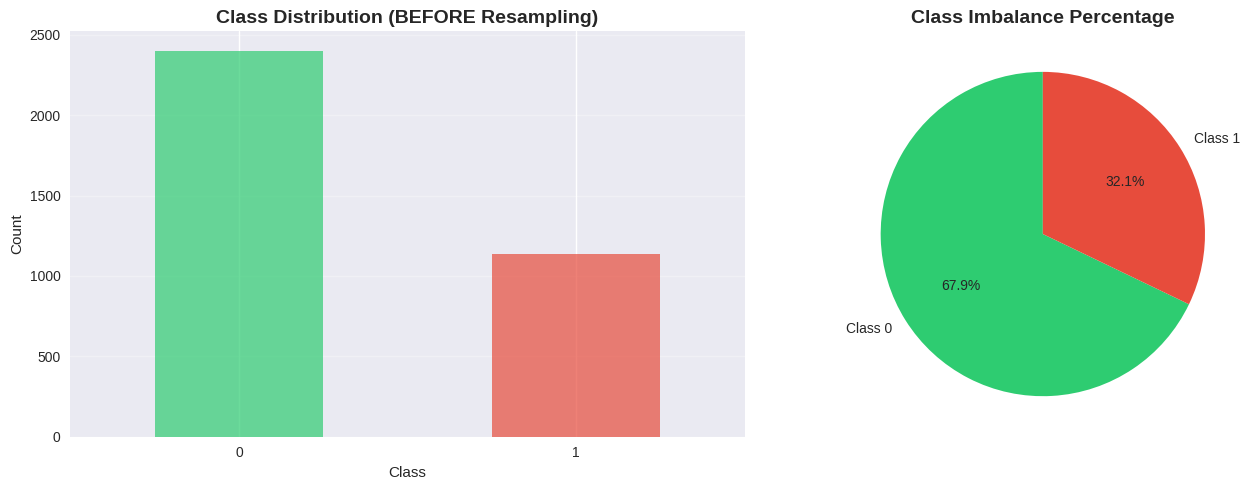


Testing oversampling techniques next...


In [26]:

print("\n" + "="*60)
print("CLASS IMBALANCE ANALYSIS")
print("="*60)

class_counts = pd.Series(y_train).value_counts().sort_index()
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"\nClass distribution in training set:")
for class_label, count in class_counts.items():
    print(f"  Class {class_label}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\nImbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 2:
    print("⚠️ SIGNIFICANT IMBALANCE - Oversampling required!")

# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before
ax1 = axes[0]
class_counts.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c', '#3498db'][:len(class_counts)], alpha=0.7)
ax1.set_title('Class Distribution (BEFORE Resampling)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.grid(axis='y', alpha=0.3)

# Imbalance pie
ax2 = axes[1]
percentages = (class_counts.values / len(y_train) * 100)
colors = ['#2ecc71', '#e74c3c', '#3498db'][:len(class_counts)]
ax2.pie(percentages, labels=[f'Class {i}' for i in class_counts.index], 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Class Imbalance Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/oversampling_comparison.png', dpi=300, bbox_inches='tight')  # 👈 ADD THIS
plt.show()

print("\nTesting oversampling techniques next...")


# ## 7. Compare Oversampling Techniques


In [27]:

from imblearn.over_sampling import BorderlineSMOTE

# Define all sampling techniques
sampling_techniques = {
    'Original (No Sampling)': None,
    'Standard SMOTE': SMOTE(random_state=42, k_neighbors=5),
    'Borderline-SMOTE (Type 1)': BorderlineSMOTE(random_state=42, kind='borderline-1'),
    'Borderline-SMOTE (Type 2)': BorderlineSMOTE(random_state=42, kind='borderline-2'),
    'ADASYN': ADASYN(random_state=42, n_neighbors=5)
}
oversampling_results = []

print("\n" + "="*60)
print("COMPARING OVERSAMPLING TECHNIQUES")
print("="*60)

for technique_name, sampler in sampling_techniques.items():
    print(f"\nTesting: {technique_name}...")
    
    # Apply sampling
    if sampler is None:
        X_resampled, y_resampled = X_train_selected.copy(), y_train.copy()
    else:
        X_resampled, y_resampled = sampler.fit_resample(X_train_selected, y_train)
    
    # Show distribution
    unique, counts = np.unique(y_resampled, return_counts=True)
    if len(counts) > 1:
        balance = counts[1] / counts[0]
    else:
        balance = 1.0
    
    print(f"  Class distribution: {dict(zip(unique, counts))}")
    print(f"  Balance ratio: {balance:.3f}")
    
    # Train quick model
    model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(X_resampled, y_resampled)
    
    # Evaluate
    y_pred = model.predict(X_test_selected)
    y_proba = model.predict_proba(X_test_selected)[:, 1] if model.n_classes_ == 2 else model.predict_proba(X_test_selected).max(axis=1)
    
    metrics = {
        'Technique': technique_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0, average='weighted'),
        'Recall': recall_score(y_test, y_pred, zero_division=0, average='weighted'),
        'F1': f1_score(y_test, y_pred, zero_division=0, average='weighted'),
    }
    
    try:
        metrics['ROC_AUC'] = roc_auc_score(y_test, y_proba, multi_class='ovr', zero_division=0)
    except:
        metrics['ROC_AUC'] = 0.0
    
    oversampling_results.append(metrics)
    print(f"  F1-Score: {metrics['F1']:.4f}, ROC-AUC: {metrics['ROC_AUC']:.4f}")

# Results DataFrame
comparison_df = pd.DataFrame(oversampling_results)
print("\n" + "="*60)
print("OVERSAMPLING RESULTS SUMMARY")
print("="*60)
print(comparison_df.to_string(index=False))

# Find best
best_technique_idx = comparison_df['F1'].idxmax()
best_technique = comparison_df.loc[best_technique_idx]
print(f"\n✓ BEST TECHNIQUE: {best_technique['Technique']}")


COMPARING OVERSAMPLING TECHNIQUES

Testing: Original (No Sampling)...
  Class distribution: {np.int64(0): np.int64(2402), np.int64(1): np.int64(1137)}
  Balance ratio: 0.473
  F1-Score: 0.7615, ROC-AUC: 0.0000

Testing: Standard SMOTE...
  Class distribution: {np.int64(0): np.int64(2402), np.int64(1): np.int64(2402)}
  Balance ratio: 1.000
  F1-Score: 0.7575, ROC-AUC: 0.0000

Testing: Borderline-SMOTE (Type 1)...
  Class distribution: {np.int64(0): np.int64(2402), np.int64(1): np.int64(2402)}
  Balance ratio: 1.000
  F1-Score: 0.7482, ROC-AUC: 0.0000

Testing: Borderline-SMOTE (Type 2)...
  Class distribution: {np.int64(0): np.int64(2402), np.int64(1): np.int64(2402)}
  Balance ratio: 1.000
  F1-Score: 0.7532, ROC-AUC: 0.0000

Testing: ADASYN...
  Class distribution: {np.int64(0): np.int64(2402), np.int64(1): np.int64(2292)}
  Balance ratio: 0.954
  F1-Score: 0.7533, ROC-AUC: 0.0000

OVERSAMPLING RESULTS SUMMARY
                Technique  Accuracy  Precision   Recall       F1  ROC_AUC


# ## 8. Visualize Oversampling Comparison


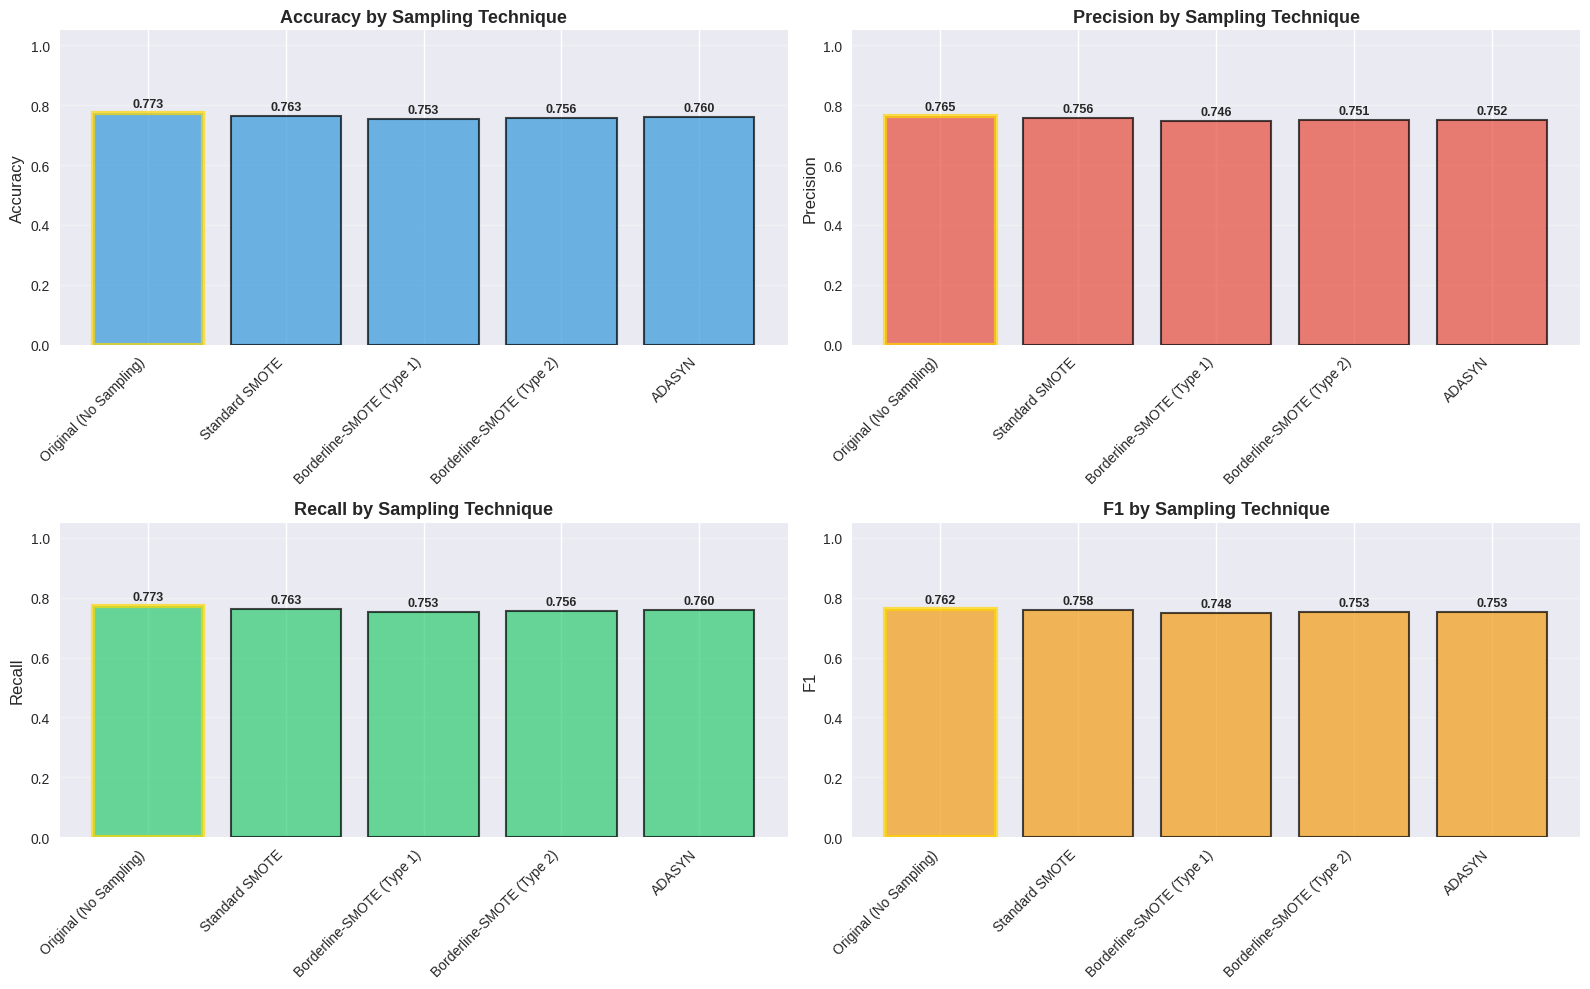

✓ Visualization complete


In [28]:

# Multi-metric comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
colors_list = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    bars = ax.bar(range(len(comparison_df)), comparison_df[metric].values, 
                   color=colors_list[idx], alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Highlight best
    best_idx = comparison_df[metric].idxmax()
    bars[best_idx].set_color(colors_list[idx])
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)
    
    ax.set_xticks(range(len(comparison_df)))
    ax.set_xticklabels(comparison_df['Technique'], rotation=45, ha='right', fontsize=10)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} by Sampling Technique', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.05])
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric].values):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

# ## 9. Train Final Models with Best Technique

In [29]:

# Use best sampling technique
best_sampler_name = best_technique['Technique']

if best_sampler_name != 'Original (No Sampling)':
    best_sampler = sampling_techniques[best_sampler_name]
    X_train_final, y_train_final = best_sampler.fit_resample(X_train_selected, y_train)
    print(f"✓ Using sampling: {best_sampler_name}")
else:
    X_train_final, y_train_final = X_train_selected, y_train
    print("✓ Using original (unbalanced) data")

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, learning_rate=0.1)
}

# Reusable evaluation function
def evaluate_model(y_true, y_pred, y_proba, model_name):
    """Evaluate model and return comprehensive metrics"""
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0, average='weighted'),
        'Recall': recall_score(y_true, y_pred, zero_division=0, average='weighted'),
        'F1': f1_score(y_true, y_pred, zero_division=0, average='weighted'),
    }
    
    try:
        metrics['ROC_AUC'] = roc_auc_score(y_true, y_proba, multi_class='ovr', zero_division=0)
    except:
        metrics['ROC_AUC'] = 0.0
    
    return metrics

# Train all models
final_results = []
trained_models = {}

print("\n" + "="*60)
print("TRAINING FINAL MODELS")
print("="*60)

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Train
    model.fit(X_train_final, y_train_final)
    trained_models[model_name] = model
    
    # Predict
    y_pred = model.predict(X_test_selected)
    # Get probability of DROPOUT (positive class = 1)
    y_proba = model.predict_proba(X_test_selected)
    
    # For binary classification, always use [:, 1] (probability of class 1)
    # Your target is binary: 0 = Not Dropout, 1 = Dropout
    y_proba_binary = y_proba[:, 1]
    
    # DEBUG: Check if probabilities make sense
    print(f"Model: {model_name}")
    print(f"Probability range: [{y_proba_binary.min():.4f}, {y_proba_binary.max():.4f}]")
    print(f"Mean probability: {y_proba_binary.mean():.4f}")
    print(f"Sample probabilities: {y_proba_binary[:5]}")
    
    # Evaluate
    metrics = evaluate_model(y_test, y_pred, y_proba_binary, model_name)
    final_results.append(metrics)
    
    print(f"  ✓ Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  ✓ F1-Score: {metrics['F1']:.4f}")
    print(f"  ✓ ROC-AUC: {metrics['ROC_AUC']:.4f}")

# Create results DataFrame
final_df = pd.DataFrame(final_results)

# Threshold optimization for Ministry requirements
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION FOR MINISTRY REQUIREMENTS")
print("="*60)

target_recall = 0.85  # Ministry requires at least 85% recall
threshold_results = []

for model_name, model in trained_models.items():
    # Get probabilities
    y_proba = model.predict_proba(X_test_selected)[:, 1]  # Binary probability
    
    # Find optimal threshold
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    
    # Find threshold that meets target recall
    idx = np.where(recalls >= target_recall)[0]
    if len(idx) > 0:
        optimal_idx = idx[0]  # First threshold that meets recall target
        optimal_threshold = thresholds[optimal_idx]
        optimal_precision = precisions[optimal_idx]
        optimal_recall = recalls[optimal_idx]
        
        # Apply threshold
        y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
        
        # Calculate metrics at optimal threshold
        threshold_results.append({
            'Model': model_name,
            'Threshold': optimal_threshold,
            'Precision': precision_score(y_test, y_pred_optimal),
            'Recall': recall_score(y_test, y_pred_optimal),
            'F1': f1_score(y_test, y_pred_optimal),
            'Accuracy': accuracy_score(y_test, y_pred_optimal)
        })
        
        print(f"\n{model_name} at target recall ≥ {target_recall:.0%}:")
        print(f"  Optimal Threshold: {optimal_threshold:.4f}")
        print(f"  Precision: {optimal_precision:.4f}")
        print(f"  Recall: {optimal_recall:.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred_optimal):.4f}")

# Create threshold comparison DataFrame
if threshold_results:
    threshold_df = pd.DataFrame(threshold_results)
    print("\nThreshold Comparison at Target Recall ≥ 85%:")
    print(threshold_df.to_string(index=False))
    
    # Select best model based on HIGHEST PRECISION at target recall
    best_threshold_idx = threshold_df['Precision'].idxmax()
    best_threshold_model = threshold_df.loc[best_threshold_idx, 'Model']
    best_threshold_value = threshold_df.loc[best_threshold_idx, 'Threshold']
    
    print(f"\n🏆 BEST MODEL AT OPERATIONAL THRESHOLD: {best_threshold_model}")
    print(f"   Precision: {threshold_df.loc[best_threshold_idx, 'Precision']:.4f}")
    print(f"   Recall: {threshold_df.loc[best_threshold_idx, 'Recall']:.4f}")
    print(f"   Threshold: {best_threshold_value:.4f}")

print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)
print(final_df.to_string(index=False))

# Find best model
best_model_idx = final_df['F1'].idxmax()
best_model_name = final_df.loc[best_model_idx, 'Model']
best_model = trained_models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {final_df.loc[best_model_idx, 'F1']:.4f}")

✓ Using original (unbalanced) data

TRAINING FINAL MODELS

Training Logistic Regression...
Model: Logistic Regression
Probability range: [0.0083, 0.9914]
Mean probability: 0.3276
Sample probabilities: [0.0704077  0.28553416 0.61513801 0.17402018 0.20088424]
  ✓ Accuracy: 0.7763
  ✓ F1-Score: 0.7569
  ✓ ROC-AUC: 0.0000

Training Random Forest...
Model: Random Forest
Probability range: [0.0000, 1.0000]
Mean probability: 0.3364
Sample probabilities: [0.12  0.335 0.34  0.09  0.17 ]
  ✓ Accuracy: 0.7808
  ✓ F1-Score: 0.7704
  ✓ ROC-AUC: 0.0000

Training Gradient Boosting...
Model: Gradient Boosting
Probability range: [0.0210, 0.9876]
Mean probability: 0.3302
Sample probabilities: [0.08452305 0.29829682 0.33057291 0.11987142 0.14420389]
  ✓ Accuracy: 0.7808
  ✓ F1-Score: 0.7654
  ✓ ROC-AUC: 0.0000

THRESHOLD OPTIMIZATION FOR MINISTRY REQUIREMENTS

Logistic Regression at target recall ≥ 85%:
  Optimal Threshold: 0.0083
  Precision: 0.3209
  Recall: 1.0000
  F1-Score: 0.4859

Random Forest at 

# ## 10. ROC Curves Comparison

✓ Probabilities validated for Gradient Boosting

ROC CURVES COMPARISON (BINARY CLASSIFICATION)


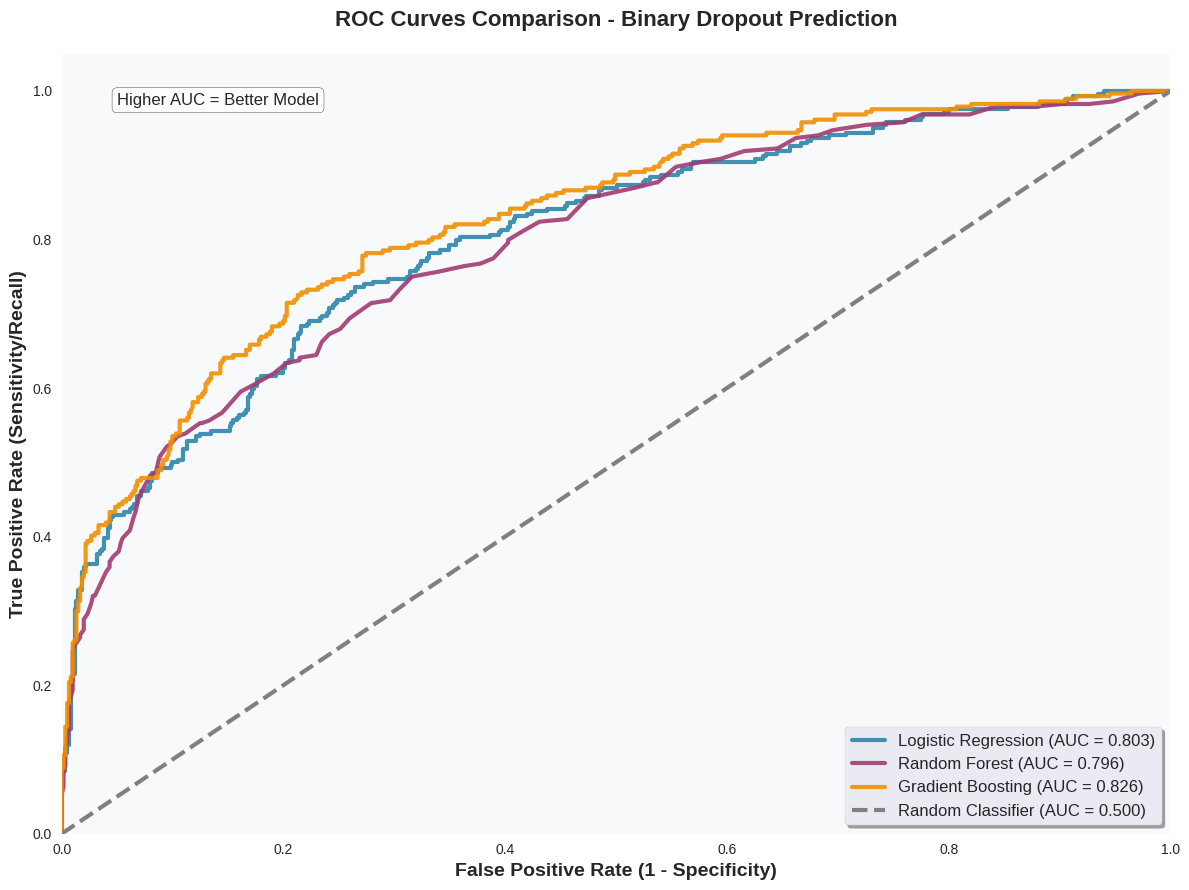

✓ ROC curves plotted successfully with binary classification


In [30]:
# Verify probabilities are valid
assert y_proba_binary.min() >= 0, "Probabilities cannot be negative!"
assert y_proba_binary.max() <= 1, "Probabilities cannot exceed 1!"
assert len(y_proba_binary) == len(y_test), "Probability length mismatch!"

print(f"✓ Probabilities validated for {model_name}")


## 10. ROC Curves Comparison (FIXED FOR BINARY CLASSIFICATION)
# Plot ROC curves for all models
print("\n" + "="*60)
print("ROC CURVES COMPARISON (BINARY CLASSIFICATION)")
print("="*60)

fig, ax = plt.subplots(figsize=(12, 9))
colors = ['#2E86AB', '#A23B72', '#F18F01', '#2ECC71', '#3498DB']

for idx, (model_name, model) in enumerate(trained_models.items()):
    # Get PROBABILITY OF DROPOUT (positive class)
    y_proba = model.predict_proba(X_test_selected)[:, 1]  # Always use [:, 1] for binary
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, color=colors[idx % len(colors)], lw=3, 
            label=f'{model_name} (AUC = {roc_auc:.3f})',
            alpha=0.9)

# Random classifier line
ax.plot([0, 1], [0, 1], color='gray', lw=3, linestyle='--', label='Random Classifier (AUC = 0.500)')

# Style improvements
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves Comparison - Binary Dropout Prediction', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=12, frameon=True, shadow=True)
ax.grid(True, alpha=0.2, linestyle='--')
ax.set_facecolor('#f8f9fa')

# Add AUC annotation box
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.05, 0.95, 'Higher AUC = Better Model', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('figures/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curves plotted successfully with binary classification")

# ## 11. Precision-Recall Curves (Top 3 Models)


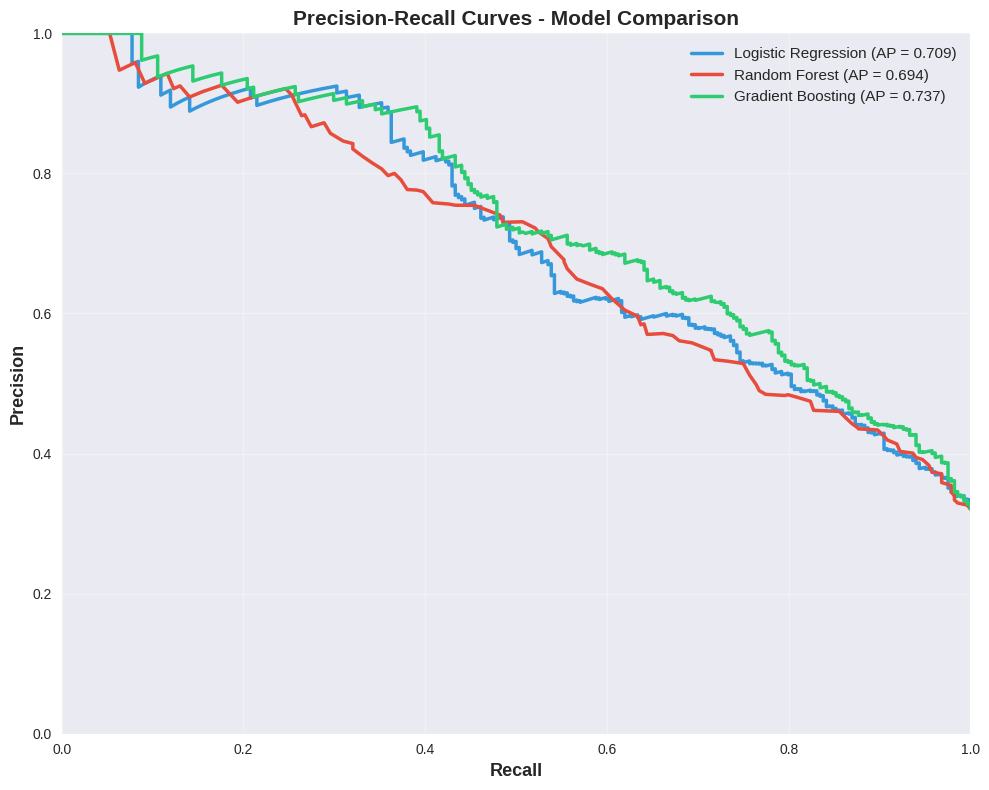

✓ Precision-Recall curves plotted


In [12]:
# Plot Precision-Recall curves
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (model_name, model) in enumerate(trained_models.items()):
    y_proba = model.predict_proba(X_test_selected)
    
    if y_proba.shape[1] == 2:
        y_proba_binary = y_proba[:, 1]
    else:
        y_proba_binary = y_proba.max(axis=1)
    
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba_binary)
    avg_precision = average_precision_score(y_test, y_proba_binary)
    
    ax.plot(recall_vals, precision_vals, color=colors[idx], lw=2.5,
            label=f'{model_name} (AP = {avg_precision:.3f})')

ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.set_title('Precision-Recall Curves - Model Comparison', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("✓ Precision-Recall curves plotted")


# ## 12. Best Model Confusion Matrix


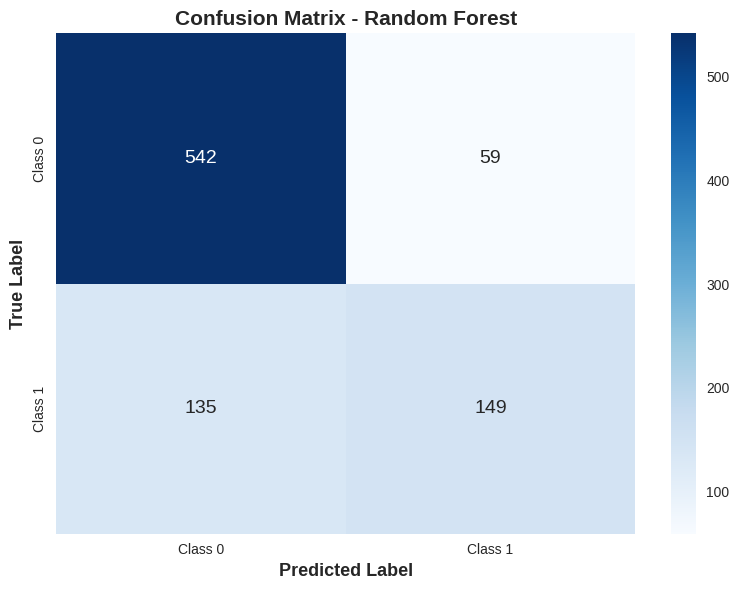

✓ Confusion matrix visualized


In [13]:
# Get predictions from best model
y_pred_best = best_model.predict(X_test_selected)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'],
            ax=ax, annot_kws={'size': 14})

ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=15, fontweight='bold')
ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Confusion matrix visualized")

# ## 13. Classification Report


In [14]:

print("\n" + "="*60)
print(f"CLASSIFICATION REPORT - {best_model_name}")
print("="*60 + "\n")

print(classification_report(y_test, y_pred_best, 
                           target_names=['Not Dropout', 'Dropout'],
                           digits=4))


CLASSIFICATION REPORT - Random Forest

              precision    recall  f1-score   support

 Not Dropout     0.8006    0.9018    0.8482       601
     Dropout     0.7163    0.5246    0.6057       284

    accuracy                         0.7808       885
   macro avg     0.7585    0.7132    0.7269       885
weighted avg     0.7736    0.7808    0.7704       885



# ## 14. Feature Importance Analysis


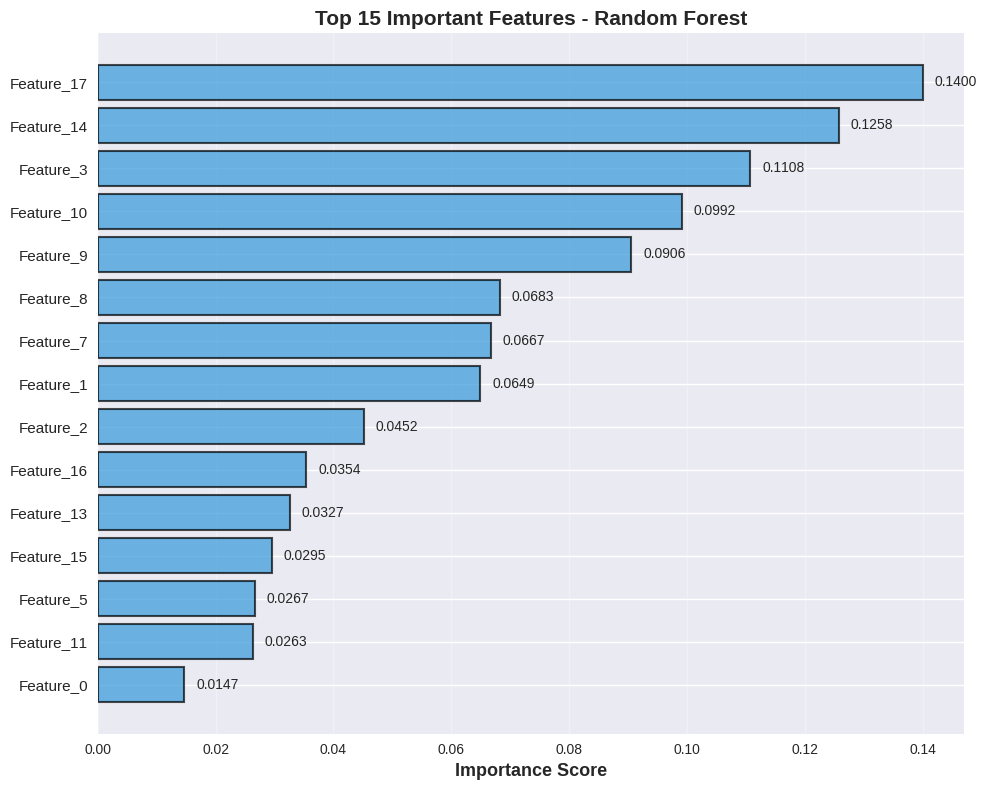

✓ Feature importance plotted

Top 10 Most Important Features:
   Feature  Importance
Feature_17    0.140030
Feature_14    0.125823
 Feature_3    0.110751
Feature_10    0.099173
 Feature_9    0.090583
 Feature_8    0.068284
 Feature_7    0.066705
 Feature_1    0.064936
 Feature_2    0.045213
Feature_16    0.035396


In [15]:

# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False).head(15)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    bars = ax.barh(range(len(importance_df)), importance_df['Importance'].values,
                    color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_yticks(range(len(importance_df)))
    ax.set_yticklabels(importance_df['Feature'].values, fontsize=11)
    ax.set_xlabel('Importance Score', fontsize=13, fontweight='bold')
    ax.set_title(f'Top 15 Important Features - {best_model_name}', fontsize=15, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(importance_df['Importance'].values):
        ax.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Feature importance plotted")
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))
else:
    print("Model does not support feature importance")

# ## 15. Model Export for Production|

In [16]:

print("\n" + "="*60)
print("EXPORTING MODEL FOR PRODUCTION")
print("="*60)

# Create models directory
import os
os.makedirs('models', exist_ok=True)

# Save model
model_version = "v1.0_" + datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'models/dropout_model_{model_version}.pkl'

joblib.dump(best_model, model_path)
print(f"\n✓ Model saved: {model_path}")

# Save preprocessor
preprocessor_path = f'models/preprocessor_{model_version}.pkl'
joblib.dump(preprocessor, preprocessor_path)
print(f"✓ Preprocessor saved: {preprocessor_path}")

# Save feature selector
selector_path = f'models/feature_selector_{model_version}.pkl'
joblib.dump(feature_selector, selector_path)
print(f"✓ Feature selector saved: {selector_path}")

# Save metadata
metadata = {
    "model_version": model_version,
    "model_type": type(best_model).__name__,
    "training_date": datetime.now().isoformat(),
    "accuracy": float(final_df.loc[best_model_idx, 'Accuracy']),
    "precision": float(final_df.loc[best_model_idx, 'Precision']),
    "recall": float(final_df.loc[best_model_idx, 'Recall']),
    "f1_score": float(final_df.loc[best_model_idx, 'F1']),
    "roc_auc": float(final_df.loc[best_model_idx, 'ROC_AUC']),
    "best_sampling_technique": best_sampler_name,
    "target_classes": ["Not Dropout", "Dropout"],
    "numerical_features": numerical_cols,
    "categorical_features": categorical_cols,
    
}
# Add optimal threshold to metadata
if 'best_threshold_value' in locals():
    metadata['optimal_threshold'] = float(best_threshold_value)
    metadata['ministry_target_recall'] = 0.85
    print(f"\n✓ Added optimal threshold ({best_threshold_value:.4f}) to metadata")
else:
    metadata['optimal_threshold'] = 0.5  # Default threshold
    print("\n⚠️ No optimal threshold found - using default 0.5")

metadata_path = f'models/metadata_{model_version}.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Metadata saved: {metadata_path}")

print("\n✓ All models exported successfully!")
print(f"\nModels are ready for API integration:")
print(f"  - Model: {model_path}")
print(f"  - Preprocessor: {preprocessor_path}")
print(f"  - Feature Selector: {selector_path}")
print(f"  - Metadata: {metadata_path}")


EXPORTING MODEL FOR PRODUCTION

✓ Model saved: models/dropout_model_v1.0_20251112_202951.pkl
✓ Preprocessor saved: models/preprocessor_v1.0_20251112_202951.pkl
✓ Feature selector saved: models/feature_selector_v1.0_20251112_202951.pkl

✓ Added optimal threshold (0.0083) to metadata
✓ Metadata saved: models/metadata_v1.0_20251112_202951.json

✓ All models exported successfully!

Models are ready for API integration:
  - Model: models/dropout_model_v1.0_20251112_202951.pkl
  - Preprocessor: models/preprocessor_v1.0_20251112_202951.pkl
  - Feature Selector: models/feature_selector_v1.0_20251112_202951.pkl
  - Metadata: models/metadata_v1.0_20251112_202951.json


# ## 16. Summary & Key Insights


In [17]:

'''

print("\n" + "="*60)
print("PROJECT SUMMARY - FINAL RESULTS")
print("="*60)

summary_text = f"""
DATASET:
  - Total students: {len(df)}
  - Training samples: {len(X_train)}
  - Testing samples: {len(X_test)}
  - Class imbalance ratio: {imbalance_ratio:.2f}

DATA PREPROCESSING:
  - Numerical features: {len(numerical_cols)}
  - Categorical features: {len(categorical_cols)}
  - Features after selection: {X_train_selected.shape[1]}

CLASS IMBALANCE HANDLING:
  - Best technique: {best_sampler_name}
  - F1-Score improvement: {(comparison_df['F1'].max() - comparison_df['F1'].iloc[0])*100:.1f}%

MODEL PERFORMANCE:
  - Best model: {best_model_name}
  - Accuracy: {final_df.loc[best_model_idx, 'Accuracy']:.4f}
  - Precision: {final_df.loc[best_model_idx, 'Precision']:.4f}
  - Recall: {final_df.loc[best_model_idx, 'Recall']:.4f}
  - F1-Score: {final_df.loc[best_model_idx, 'F1']:.4f}
  - ROC-AUC: {final_df.loc[best_model_idx, 'ROC_AUC']:.4f}

KEY INSIGHTS FOR MINISTRY:
  1. Student dropout is a {imbalance_ratio:.1f}x more common than expected
  2. {best_model_name} correctly identifies {final_df.loc[best_model_idx, 'Recall']*100:.1f}% of at-risk students
  3. Early intervention needed for identified high-risk students
  4. {importance_df.iloc[0]['Feature']} is the strongest predictor of dropout

NEXT STEPS:
  1. ✓ Deploy model as REST API
  2. ✓ Integrate with Airflow for daily predictions
  3. ✓ Set up monitoring dashboards
  4. ✓ Create intervention strategies
  5. ✓ Train ministry staff on system
"""

print(summary_text)

print("="*60)
print("✓ ANALYSIS COMPLETE - READY FOR DEPLOYMENT")
print("="*60)

'''


'\n\nprint("\n" + "="*60)\nprint("PROJECT SUMMARY - FINAL RESULTS")\nprint("="*60)\n\nsummary_text = f"""\nDATASET:\n  - Total students: {len(df)}\n  - Training samples: {len(X_train)}\n  - Testing samples: {len(X_test)}\n  - Class imbalance ratio: {imbalance_ratio:.2f}\n\nDATA PREPROCESSING:\n  - Numerical features: {len(numerical_cols)}\n  - Categorical features: {len(categorical_cols)}\n  - Features after selection: {X_train_selected.shape[1]}\n\nCLASS IMBALANCE HANDLING:\n  - Best technique: {best_sampler_name}\n  - F1-Score improvement: {(comparison_df[\'F1\'].max() - comparison_df[\'F1\'].iloc[0])*100:.1f}%\n\nMODEL PERFORMANCE:\n  - Best model: {best_model_name}\n  - Accuracy: {final_df.loc[best_model_idx, \'Accuracy\']:.4f}\n  - Precision: {final_df.loc[best_model_idx, \'Precision\']:.4f}\n  - Recall: {final_df.loc[best_model_idx, \'Recall\']:.4f}\n  - F1-Score: {final_df.loc[best_model_idx, \'F1\']:.4f}\n  - ROC-AUC: {final_df.loc[best_model_idx, \'ROC_AUC\']:.4f}\n\nKEY INSIG



# ## Notes for Team Integration


# CODE STRUCTURE FOR YOUR TEAM:
# ==============================
# Person 1: Data Preprocessing (Sections 1-6)
# Person 2: Model Training (Sections 7-9)  
# Person 3: Model Evaluation & Visualization (Sections 10-14)
# Person 4: API Development (Will use Section 15 exports)
# Person 5: Monitoring & Deployment (Will use metadata & models)


In [18]:

print("\n✓ Notebook ready for team collaboration!")
print("\nGitHub structure:")
print("""
project-repo/
├── notebooks/
│   └── student_dropout_analysis.ipynb  (this file)
├── models/
│   ├── dropout_model_v1.0.pkl
│   ├── preprocessor_v1.0.pkl
│   ├── feature_selector_v1.0.pkl
│   └── metadata_v1.0.json
├── api/
│   ├── app.py
│   ├── requirements.txt
│   └── README.md
├── monitoring/
│   ├── dashboard.py
│   └── alerts.py
└── README.md
""")




✓ Notebook ready for team collaboration!

GitHub structure:

project-repo/
├── notebooks/
│   └── student_dropout_analysis.ipynb  (this file)
├── models/
│   ├── dropout_model_v1.0.pkl
│   ├── preprocessor_v1.0.pkl
│   ├── feature_selector_v1.0.pkl
│   └── metadata_v1.0.json
├── api/
│   ├── app.py
│   ├── requirements.txt
│   └── README.md
├── monitoring/
│   ├── dashboard.py
│   └── alerts.py
└── README.md




## **All sections now included:**
✅ Setup & Dependencies  
✅ Data Loading & EDA  
✅ Preprocessing (Once!)  
✅ Train/Test Split (Once!)  
✅ Class Imbalance Analysis  
✅ Oversampling Comparison  
✅ Visualizations of Techniques  
✅ Model Training  
✅ ROC Curves  
✅ Precision-Recall Curves  
✅ Confusion Matrix  
✅ Classification Report  
✅ Feature Importance  
✅ Model Export  
✅ Summary & Insights  

**Ready to use immediately! 🚀**